In [1]:
from google.cloud import vision
import os

In [6]:
# 서비스 계정 키 환경변수 등록
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = (
    "C:/emotion_letter/app/tests/data/vision-key.json"
)

In [7]:
from typing import Dict, Any, List


def run_gcp_ocr_with_boxes(image_path: str) -> Dict[str, Any]:
    """손글씨 텍스트 + bounding box 좌표를 추출"""
    client = vision.ImageAnnotatorClient()
    with open(image_path, "rb") as f:
        content = f.read()

    image = vision.Image(content=content)
    response = client.text_detection(image=image)

    if response.error.message:
        raise Exception(f"Vision API Error: {response.error.message}")

    texts = response.text_annotations

    results = {"full_text": texts[0].description if texts else "", "boxes": []}

    for annotation in texts[1:]:  # [0]은 전체 문장, 이후부터 단어/문자 단위
        vertices = [(v.x, v.y) for v in annotation.bounding_poly.vertices]
        results["boxes"].append({"text": annotation.description, "vertices": vertices})

    return results

# Bounding Box 시각화 함수

In [8]:
import cv2
import matplotlib.pyplot as plt


def visualize_ocr_boxes(image_path: str, ocr_result: Dict[str, Any]) -> None:
    """OCR 결과의 bounding box를 이미지 위에 시각화"""
    img = cv2.imread(image_path)
    img_boxed = img.copy()

    for box in ocr_result["boxes"]:
        vertices = box["vertices"]
        pts = [(v[0], v[1]) for v in vertices]

        # 사각형 그리기 (초록색 박스)
        for i in range(len(pts)):
            cv2.line(img_boxed, pts[i], pts[(i + 1) % 4], (0, 255, 0), 2)

    # 시각화 출력
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(img_boxed, cv2.COLOR_BGR2RGB))
    plt.title("🔲 OCR Bounding Boxes on Handwritten Letter")
    plt.axis("off")
    plt.show()

# 테스트 실행 코드

=== OCR 텍스트 결과 ===
To. 철수에게
안녕 철수야. 나 윤재야. 잘 지내지? 요즘 날씨가 제법 선선해져서
산책하기도 좋고 공부나 일 하기에도 조금은 덜 지치네
from. 윤재가
감지된 단어/문자 수: 37


c:\emotion_letter\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


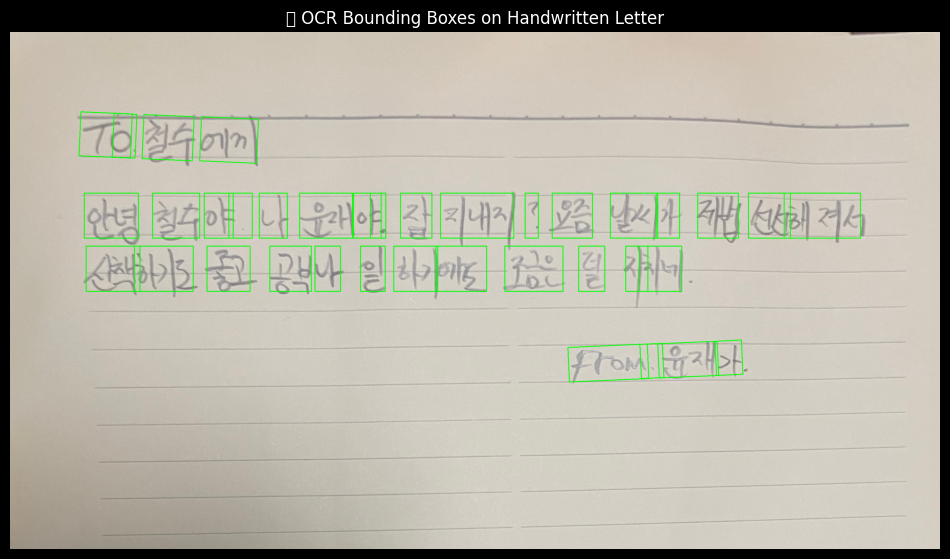

In [9]:
image_path = "C:/emotion_letter/app/tests/data/sample_letter2.jpg"

ocr_result = run_gcp_ocr_with_boxes(image_path)  # ← 딕셔너리 반환

print("=== OCR 텍스트 결과 ===")
print(ocr_result["full_text"])  # 문자열 출력
print(f"감지된 단어/문자 수: {len(ocr_result['boxes'])}")
# 박스 시각화
visualize_ocr_boxes(image_path, ocr_result)